## Assignment 12

Using section 8.4 in Deep Learning with Python as a guide, implement a variational autoencoder using the MNIST data set and save a grid of 15 x 15 digits to the `results/vae` directory. If you would rather work on a more interesting dataset, you can use the <b>CelebFaces Attributes</b> Dataset instead.

In [1]:
## Importing libraries required for this activity
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import numpy as np

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
## Defining the parameters and input image
img_shape = (28,28, 1)
batch_size = 16
latent_dim = 2

input_img = tensorflow.keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding ='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding = 'same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(64, 3, padding = 'same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding = 'same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

##### Latent-space-sampling function

In [3]:
## Defining the sampling function

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

##### VAE decoder network, mapping latent space points to images

In [4]:
decoder_input = layers.Input(K.int_shape(z)[1:])
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

In [5]:
# View summary of decoder
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 12544)             37632     
_________________________________________________________________
reshape (Reshape)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 56,385
Trainable params: 56,385
Non-trainable params: 0
_________________________________________________________________


##### Custom layer used to compute the VAE loss

In [7]:
class CustomVariationalLayer(tensorflow.keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = tensorflow.keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([input_img, z_decoded])

##### Training the MNIST VAE

In [8]:
from tensorflow.keras.datasets import mnist
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

(x_train, _), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None, shuffle=True, epochs=10, batch_size=batch_size, validation_data=(x_test, None))

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_1[0][0]                   
____________________________________________________________________________________________

C:\Users\meena\anaconda3\envs\environment\lib\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 192s 3ms/sample - loss: 1772485607.6478 - val_loss: 0.2011
Epoch 2/10
60000/60000 [==============================] - 188s 3ms/sample - loss: 0.1972 - val_loss: 0.1934
Epoch 3/10
60000/60000 [==============================] - 193s 3ms/sample - loss: 0.1911 - val_loss: 0.1889
Epoch 4/10
60000/60000 [==============================] - 182s 3ms/sample - loss: 0.1878 - val_loss: 0.1861
Epoch 5/10
60000/60000 [==============================] - 179s 3ms/sample - loss: 0.1859 - val_loss: 0.1851
Epoch 6/10
60000/60000 [==============================] - 179s 3ms/sample - loss: 0.1845 - val_loss: 0.1834
Epoch 7/10
60000/60000 [==============================] - 181s 3ms/sample - loss: 0.1836 - val_loss: 0.1829
Epoch 8/10
60000/60000 [==============================] - 180s 3ms/sample - loss: 0.1827 - val_loss: 0.1825
Epoch 9/10
60000/60000 [==============================] - 180s 3ms/sample - loss: 0.1821 - val_loss: 0.1829
Epoch 10/10
60000/60000 [=====

#### Sampling a grid of points from the 2D latent space and decoding them to images

grid_x
[-1.64485363e+00 -1.20404696e+00 -9.20822976e-01 -6.97141435e-01
 -5.03965367e-01 -3.28072108e-01 -1.61844167e-01 -1.39145821e-16
  1.61844167e-01  3.28072108e-01  5.03965367e-01  6.97141435e-01
  9.20822976e-01  1.20404696e+00  1.64485363e+00]
grid_y
[-1.64485363e+00 -1.20404696e+00 -9.20822976e-01 -6.97141435e-01
 -5.03965367e-01 -3.28072108e-01 -1.61844167e-01 -1.39145821e-16
  1.61844167e-01  3.28072108e-01  5.03965367e-01  6.97141435e-01
  9.20822976e-01  1.20404696e+00  1.64485363e+00]


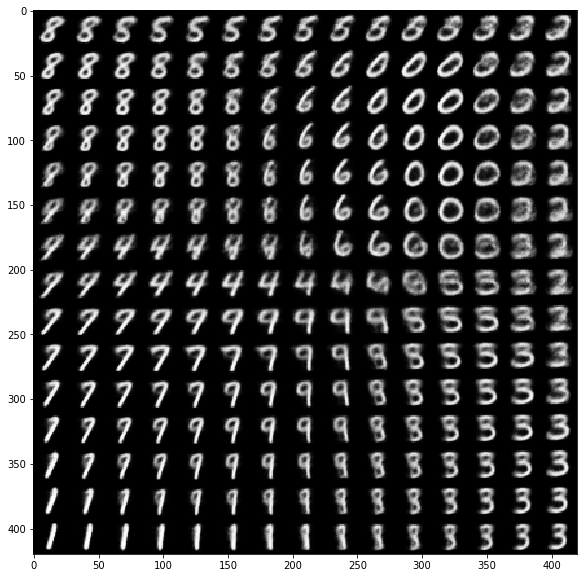

In [10]:
import matplotlib.pyplot as plt
from scipy.stats import norm
from pathlib import Path

results_dir = Path('C:/Users/meena/Documents/DSC_650/DSC650_Submissions_MS/Week12/assignment12/results/vae')

n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
print("grid_x")
print(grid_x)
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
print("grid_y")
print(grid_y)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
img_file = results_dir.joinpath('Assignment_12_15x15_Grid.png')
plt.savefig(img_file)
plt.show()